In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from icecream import ic
import pandas as pd
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

## MODELS ##
from dataset import  DatasetCelebA_Sketch
from discriminator import Discriminator 
from generator import Generator

from CVAE_Encoder_2 import Encoder
from CVAE_Decoder_2 import Decoder


e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
ATTR_DIM = 4
resize =  transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([128,128])])

def read_images(index, display=1):
    EXCEL_PATH = "E:\Lucru\Dizertatie\Cod\Face_Synthesis\Database\celebA_medium_2.xlsx"
    DATASET_PATH = "E:\Lucru\Dizertatie\Baze de date\CelebA_crop\CelebA_Crop_medium\\"
    SKETCH_DATASET_PATH = "E:\Lucru\Dizertatie\Baze de date\CelebA_crop\CelebA_Sketch_Crop_medium\\"

    resize =  transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([128,128])])

    transf = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([128,128]),
                                transforms.ToTensor()])

    transf_sketch = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize([128,128]),
                                transforms.ToTensor()])

    df = pd.read_excel(EXCEL_PATH)
    data = df["image_id"]
    labels = df.iloc[:, 1:(ATTR_DIM + 1)]
    # labels = df["Male"]

    # index = 17

    # 25 - nice female
    # 31 - male

    img = cv2.imread(DATASET_PATH + data[index])
    # img = cv2.imread('E:\Lucru\Dizertatie\Cod\Image-to-Sketch\source\\Vaman_Teodora.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    sketch_img = cv2.imread(SKETCH_DATASET_PATH + data[index])
    # sketch_img = cv2.imread('E:\Lucru\Dizertatie\Cod\Image-to-Sketch\destination\\Vaman_Teodora.jpg')
    sketch_img = cv2.cvtColor(sketch_img, cv2.COLOR_BGR2RGB)

    batch_data = img
    batch_data = transf(batch_data)

    batch_sketch_data = sketch_img
    batch_sketch_data = transf_sketch(batch_sketch_data)

    batch_labels = labels.iloc[index].values
    pil_img = resize(img)
    pil_img_sketch = resize(sketch_img)
    if display == 1 :
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.title("Imagine Originala")
        plt.imshow(np.asarray(pil_img))
        plt.subplot(1, 2, 2)
        plt.imshow(np.asarray(pil_img_sketch))
        plt.title("Imagine Schita reala")

    # print(f"Attributes [Gender Smiling Eyeglasses No_Beard] = {labels.iloc[index].values}")
    # Gender Smiling Eyeglasses No_Beard
    return batch_sketch_data, batch_data, batch_labels

# sketch_img, img, labels = read_images(7)

In [30]:
## DEFINE THE MODELS
encoder = Encoder(attribute_number=ATTR_DIM)
decoder = Decoder(attribute_number=ATTR_DIM)
retea_G2 = Generator(attribute_number=ATTR_DIM)
retea_D2 = Discriminator(img_size=128, attribute_number=ATTR_DIM)
retea_G2.cuda()
retea_D2.cuda()
encoder.cuda()
decoder.cuda()
encoder.eval()
decoder.eval()
retea_G2.eval()
retea_D2.eval()

# decoder.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Stage1_Attr2Sketch\\retea_Decoder.pt'))
# encoder.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Stage1_Attr2Sketch\\retea_Encoder.pt'))

decoder.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Stage2_Sketch2Sketch\cropface_10epoci\\retea_Decoder_10epoci.pt'))
encoder.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Stage2_Sketch2Sketch\cropface_10epoci\\retea_Encoder_10epoci.pt'))

retea_D2.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Stage2_Sketch2Sketch\\7epoci_128\\retea_D_Stage2.pt'))
retea_G2.load_state_dict(torch.load('E:\Lucru\Dizertatie\Cod\Face_Synthesis\Stage2_Sketch2Sketch\\7epoci_128\\retea_G_Stage2.pt'))


Using cache found in C:\Users\Teodora/.cache\torch\hub\pytorch_vision_v0.10.0


<All keys matched successfully>

In [26]:
DEVICE = 'cuda'

def synth_images(attributes, display=1, index=0):
    sketch_img, img, labels = read_images(index, display=0)
    
    esantioane_proba = torch.stack([sketch_img], dim=0)
    etichete_proba = torch.FloatTensor([attributes])

    esantioane_proba = esantioane_proba.to(torch.device(DEVICE))
    etichete_proba = etichete_proba.to(torch.device(DEVICE))
    zgomot_proba = torch.FloatTensor(esantioane_proba.shape[0], 256).normal_(0, 1)
    zgomot_proba  = zgomot_proba.to(torch.device(DEVICE))

    ic(etichete_proba.shape)
    zgomot_embedded, schita_embedded, encode_text = encoder(noise=zgomot_proba, attr_text=etichete_proba, sketch=esantioane_proba, detach_flag=True)
    reconstructed_sketch_images, reconstructed_fake_images = decoder(zgomot_embedded[0], schita_embedded[0], detach_flag=True)

    imagini_generate_Stage2 = retea_G2(reconstructed_fake_images, encode_text).detach()

    reconstructed_sketch_images = torch.squeeze(reconstructed_fake_images, 0)
    reconstructed_sketch_images = reconstructed_sketch_images.to(torch.device('cpu'))

    reconstructed_fake_images = torch.squeeze(reconstructed_fake_images, 0)
    reconstructed_fake_images = reconstructed_fake_images.to(torch.device('cpu'))

    imagini_generate_Stage2 = torch.squeeze(imagini_generate_Stage2, 0)
    imagini_generate_Stage2 = imagini_generate_Stage2.to(torch.device('cpu'))

    print(f"Attributes [Male Young Eyeglasses Bangs] = {attributes}")
    
    if display == 2:
        plt.figure(figsize=(10,40))
        plt.subplot(1, 2, 2)
        plt.imshow(np.transpose(imagini_generate_Stage2,(1,2,0)), cmap='gray')
        plt.title(f"imagini_generate_Stage2 \n Atribute = {attributes}")
        plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(reconstructed_fake_images,(1,2,0)), cmap='gray')
        plt.title(f"reconstructed_fake_images \n Atribute = {attributes}")
        plt.show()



# s,n = synth_images([1,1,1,1])
# synth_images([1,1,0,1], index=25)

ic| etichete_proba.shape: torch.Size([1, 4])


Attributes [Male Young Eyeglasses Bangs] = [0, 1, 0, 0]


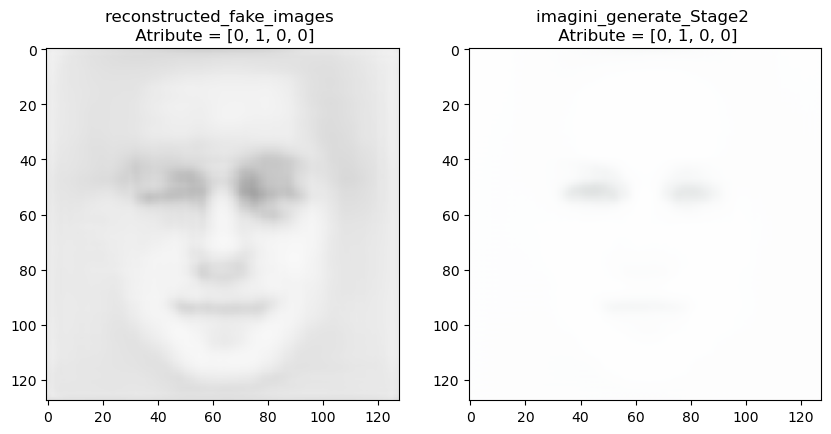

In [27]:
# index cu rezultate frumoase: 25(femeie), 7(barbat) 472(bărbat)
# Male	Young	Eyeglasses	Bangs

synth_images([0,1,0,0], index=12, display=2)
# synth_images([1,0,0,], index=3569, display=4)



# Random Face Generator

Attributes [Gender Smiling Eyeglasses No_Beard] = [0, 0, 0, 0]


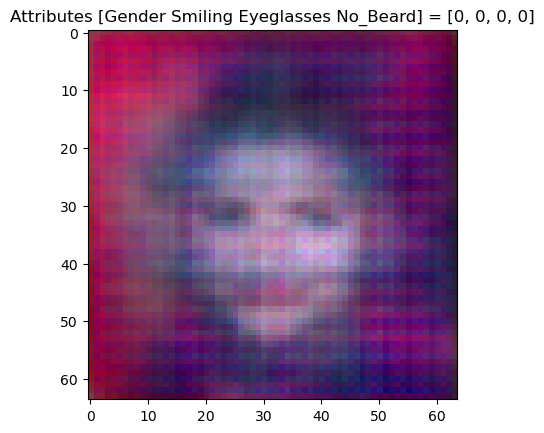

In [6]:

def random_image():
    random_index = random.randint(0, 80000)
    synth_images([0,0,0,0], index=random_index, display=0)

random_image()
